# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом, и точно не будет работать из коробки на Windows.

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [ ]:
# Harry Potter -- uncomment
#!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

# Cards -- uncomment
#!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
#im doing catrds wooooo yeaaaaa wohooooo

#!unzip -q data.zip

# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [ ]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [ ]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        # you need: xmin ymin xmax ymax, class in dict
        #res =  ### YOUR CODE HERE ###
        xmin = int(member.find("bndbox/xmin").text)
        ymin = int(member.find("bndbox/ymin").text)
        xmax = int(member.find("bndbox/xmax").text)
        ymax = int(member.find("bndbox/ymax").text)
        class_name = member.find("name").text
        class_id = class_dict[class_name]
        res = [xmin, ymin, xmax, ymax, class_id]
        bboxes.append(res)

    return bboxes

In [ ]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        ### YOUR CODE HERE ###

        fname = self.filenames[idx]
        image = np.array(Image.open(fname).convert("RGB"))
        bboxes = get_xml_data(fname, self.root, self.class_dict)

        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        ### YOUR CODE HERE ###
        return len(self.filenames)
        return

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [ ]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [ ]:
def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break
        # Вот тут нужно выполнить permute (вспомните где у torch каналы, а где они у matplotlib)
        # И откатить нормализацию (просто обратное преобразование)
        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv
        img = images[i].permute(1, 2, 0).numpy()
        img = img * std + mean

        ax.imshow(img)

        for bbox in bboxes[i]:
            xmin, ymin, xmax, ymax, class_id = bbox
            class_name = train_ds.class_dict_inv[class_id]

            rect = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor="g", facecolor="none")
            ax.add_patch(rect)

            ax.text(xmin, ymin - 5, f"{class_name}", fontsize=12, color="g")

    fig.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://gcdnb.pbrd.co/images/n8BnhhfCgYnQ.png)

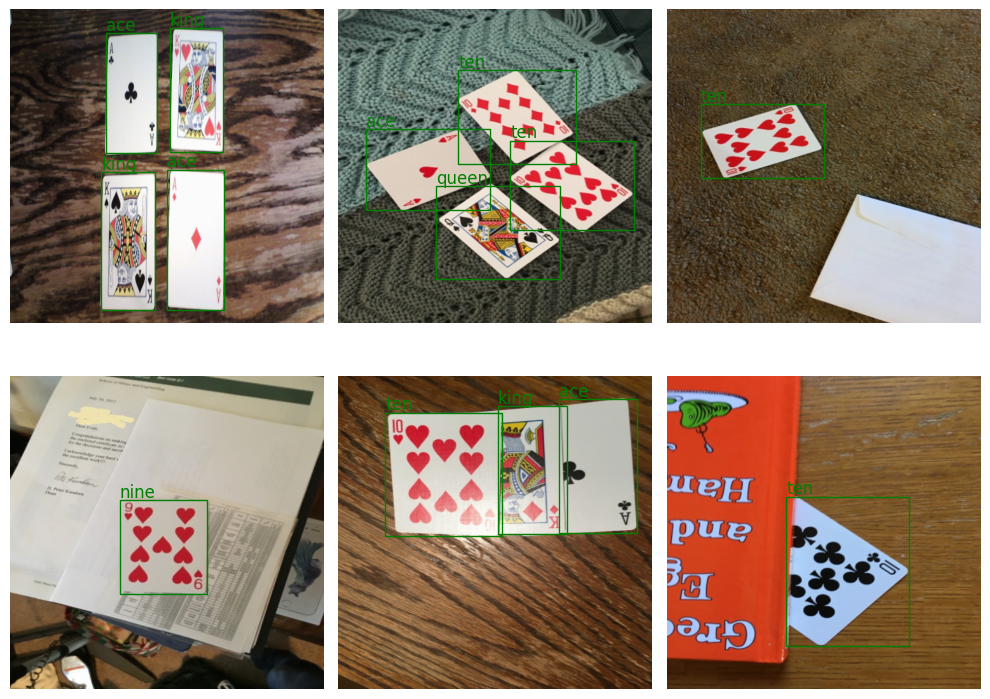

In [ ]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.
## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и сгенерировать тензор размера Bx16x16x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности, это сетка 16 на 16.

В каналах у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "пиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

In [ ]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
      for box in boxes:
          xmin, ymin, xmax, ymax, classes = map(
              torch.squeeze, torch.split(imgs.new_tensor(box), 1, dim=-1)
          )

          # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
          x_cell = w / downsample # TODO размер клетки по X в пикс
          y_cell = h / downsample # TODO размер клетки по Y в пикс
          w_box = (xmax - xmin) / w # TODO ширина бокса отнормированная
          h_box = (ymax - ymin) / h # TODO высота бокса отнормированная

          # Посчитайте координаты центра и сдвиги
          cx = (xmin + xmax) / 2 #/ w # TODO (координаты центра в исходных координатах)
          cy = (ymin + ymax) / 2 #/ h # TODO
          cx_idx = int((cx // downsample).squeeze()) # TODO (посчитайте индекс центра на карте признаков размера 16x16. Это будут как раз координаты пикселя, куда мы запишем параметры коробки)
          cy_idx = int((cy // downsample).squeeze()) # TODO

          cx_box = cx // downsample - cx_idx # TODO (посчитайте сдивиги относительно cx_idx)
          cy_box = cy // downsample - cy_idx # TODO

          target[i, :, cy_idx, cx_idx] = torch.stack(
              [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
          )

    return {"image": imgs, "target": target}

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

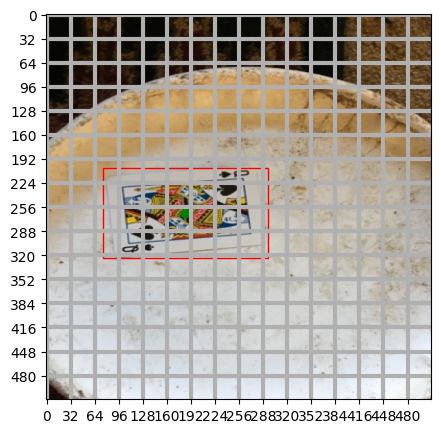

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Выход нашей сетки будет несколько больше, чем Bx16x16x6. Почему?

Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами.

То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.

Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [ ]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    ### YOUR CODE HERE ###

    boxes = []

    for i in range(b):
        for cy in range(h):
            for cx in range(w):
                box = pred[i, :4, cy, cx]
                confidence = pred[i, 4, cy, cx]
                class_probs = pred[i, 5:, cy, cx]

                # Check if the box contains an object based on confidence
                if confidence > threshold:
                    # Decode box parameters
                    cx_box, cy_box, w_box, h_box = box
                    cx_box = (cx + cx_box) * upsample
                    cy_box = (cy + cy_box) * upsample
                    w_box *= img_w
                    h_box *= img_h

                    # Decode class probabilities
                    class_id = torch.argmax(class_probs)

                    # Append the decoded box to the list
                    boxes.append([cx_box - w_box / 2, cy_box - h_box / 2, cx_box + w_box / 2, cy_box + h_box / 2, class_id.item()])

    return boxes

## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [ ]:
C = len(train_ds.class_dict) # Количество классов в вашем датасете, хоть руками посчитайте, хоть подтяните из словаря классов


class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        ### YOUR CODE HERE ###
        #self.resnet_blocks = nn.Sequential(*list(model.children())[:-1])

        self.resnet_blocks = nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4
        )

        # Additional convolutional blocks
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 5 + C, kernel_size=3, padding=1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, img):
        ### YOUR CODE HERE ###
        x = self.resnet_blocks(img)
        x = self.conv_blocks(x)
        x = self.sigmoid(x)

        return x

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)


* Ниже есть assert. Если вы экспериментируете с лоссом, он не будет проходить, не обращайте на него внимание. Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. assert написан для 3 классов, в задаче с картами их 6. Подумайте как зависит индексация от параметра C и используйте его.

In [ ]:
import torch.nn.functional as F
def special_loss(pred, target, check=False, C=C):
    ### YOUR CODE HERE ###

    pred_cx, pred_cy, pred_w, pred_h, pred_conf, pred_cls = torch.split(pred[:,:6,:,:], 1, dim=1)
    target_cx, target_cy, target_w, target_h, target_conf, target_cls = torch.split(target[:,:6,:,:], 1, dim=1)

    obj_mask = target_conf == 1
    noobj_mask = target_conf == 0

    # Localization loss - MSE по координатам бокса там, где есть детектируемый объект
    localization_loss = F.mse_loss(pred_cx[obj_mask], target_cx[obj_mask], reduction="sum") + \
                        F.mse_loss(pred_cy[obj_mask], target_cy[obj_mask], reduction="sum")

    # Box loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    box_loss = F.mse_loss(torch.sqrt(pred_w[obj_mask]), torch.sqrt(target_w[obj_mask]), reduction="sum") + \
               F.mse_loss(torch.sqrt(pred_h[obj_mask]), torch.sqrt(target_h[obj_mask]), reduction="sum")

    # Classification loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    pred_argmax = pred[:, 5:,:,:][obj_mask.expand(-1,C,-1,-1)]
    #display(torch.argmax(pred[:, 5:,:,:], axis = 1).unsqueeze(1).shape)
    classification_loss = F.cross_entropy(pred[:, 5:,:,:][obj_mask.expand(-1,C,-1,-1)].view(-1, C), target_cls[obj_mask].long(), reduction="sum")

    # Confidence loss - Бинарная кросс-энтропия факта наличия объекта
    # ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1)
    confidence_loss = F.binary_cross_entropy(pred_conf[obj_mask], target_conf[obj_mask], reduction="sum") + \
                      0.1 * F.binary_cross_entropy(pred_conf[noobj_mask], target_conf[noobj_mask], reduction="sum")

    if not check:
        return localization_loss + box_loss + classification_loss + confidence_loss

    else:
        return localization_loss, box_loss, classification_loss, confidence_loss

In [ ]:
# localization box classification confidence - возвращаются в таком порядке, можно сравнить
assert special_loss(torch.zeros((10, 8, 16, 16)), torch.ones((10, 8, 16, 16)), check=True, C=3) == (torch.tensor(5120.), torch.tensor(5120.), torch.tensor(2812.4465), torch.tensor(256000.))

# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [ ]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS = 15 # Harry Potter 20, Cards 15
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        ### YOUR CODE HERE ###
        batch["image"] = batch["image"].to(device)
        batch["target"] = batch["target"].to(device)

        # Forward pass
        predictions = model(batch["image"])

        # Compute loss
        loss = special_loss(predictions, batch["target"], C=len(train_ds.class_dict))

        # Backward pass and optimization
        opt.zero_grad()
        loss.backward()
        opt.step()

        epoch_losses.append(loss.item())

    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 0 done; Train loss 99.870;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1 done; Train loss 48.739;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2 done; Train loss 42.597;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3 done; Train loss 40.306;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4 done; Train loss 38.302;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5 done; Train loss 37.853;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6 done; Train loss 34.085;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7 done; Train loss 31.907;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8 done; Train loss 31.040;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9 done; Train loss 29.844;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10 done; Train loss 29.685;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11 done; Train loss 28.309;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12 done; Train loss 28.570;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13 done; Train loss 26.761;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14 done; Train loss 25.516;


Запустим обученный детектор на тестовых изображениях:

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [ ]:
# Нужно сделать предсказание и переложить результат на cpu
images, targets = batch["image"], batch["target"]
with torch.no_grad():
    predictions = model(images.to(device)).cpu().detach()
### YOUR CODE HERE ###

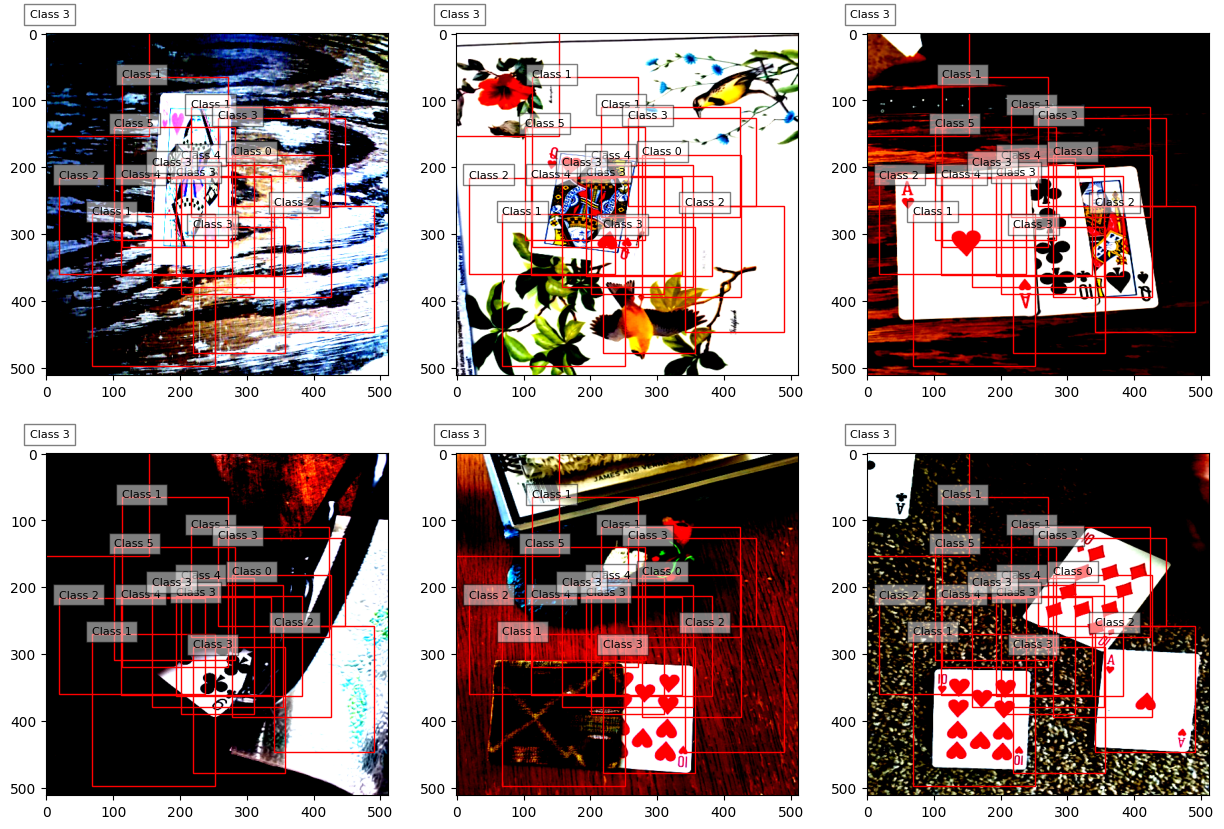

In [ ]:
# Сделайте визуализацию. Поиграйтесь с threshold, скорее всего нужно понизить до ~0.1
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

decoded_predictions = decode_prediction(predictions, threshold=0.1)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, ax in enumerate(axes.flatten()):
    img = images[i].permute(1, 2, 0).numpy()
    ax.imshow(img)

    for box in decoded_predictions:
        xmin, ymin, xmax, ymax, class_id = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor="g", facecolor="none")
        ax.add_patch(rect)
        ax.text(xmin, ymin, f"Class {int(class_id)}", bbox=dict(facecolor="white", alpha=0.5), fontsize=8)

plt.show()
### YOUR CODE HERE ###

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

In [ ]:
display(decoded_predictions)

[[tensor(112.7611), tensor(64.9243), tensor(271.2686), tensor(319.1043), 1],
 [tensor(-25.2597), tensor(-24.3925), tensor(153.3366), tensor(152.5400), 3],
 [tensor(101.5637), tensor(139.5534), tensor(282.4812), tensor(308.5234), 5],
 [tensor(18.4563), tensor(215.9503), tensor(237.5490), tensor(360.0499), 2],
 [tensor(200.9491), tensor(186.0663), tensor(311.0713), tensor(389.9373), 4],
 [tensor(193.3825), tensor(212.5034), tensor(382.6254), tensor(363.5547), 3],
 [tensor(277.9077), tensor(181.3658), tensor(426.1789), tensor(394.7507), 0],
 [tensor(111.4911), tensor(214.9446), tensor(336.6161), tensor(361.1071), 4],
 [tensor(157.5896), tensor(196.6218), tensor(354.4775), tensor(379.8342), 3],
 [tensor(219.0089), tensor(290.0358), tensor(357.0029), tensor(477.9749), 3],
 [tensor(216.2702), tensor(109.9257), tensor(423.7531), tensor(274.0863), 1],
 [tensor(256.4892), tensor(126.4013), tensor(447.5321), tensor(258.0054), 3],
 [tensor(341.3858), tensor(257.7369), tensor(490.6177), tensor(446

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO v8 от ultralytics.

In [ ]:
!pip install ultralytics

## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [ ]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

In [ ]:
def annotation2txt(bboxes, w_im, h_im):
    ### YOUR CODE HERE ###
    lines = []

    for box in bboxes:
        class_id = int(box[4])
        x_center = (box[0] + box[2]) / 2
        y_center = (box[1] + box[3]) / 2
        width = box[2] - box[0]
        height = box[3] - box[1]

        x_center /= w_im
        y_center /= h_im
        width /= w_im
        height /= h_im

        line = f"{class_id} {x_center} {y_center} {width} {height}"
        lines.append(line)

    return lines

In [ ]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )

    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [ ]:
# Собираем YAML

nc = len(train_ds.class_dict) # Укажите число классов. Хоть руками, хоть по-умному посчитайте (см. class_dict)
names = list(train_ds.class_dict.keys()) # Укажите имена классов. Хоть руками, хоть по-умному посчитайте, это массив строк (см. class_dict)
display(nc)
display(list(names))


with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

6

['king', 'jack', 'ace', 'ten', 'nine', 'queen']

## Задание 5.2. 1.5 балла.

Обучите модель YOLO v8 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель нужно взять необученную!

Подсказка: подумайте зачем вам data.yaml и что такое yolov8n.yaml (не стесняйтесь гуглить)

In [ ]:
import ultralytics

### YOUR CODE HERE ###

data_yaml_path = "data.yaml"
yolo = ultralytics.YOLO(model="yolov8n")
yolo.train(data=data_yaml_path, epochs=5)

Ultralytics YOLOv8.0.220 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=Fals

train: Scanning /content/train/labels.cache... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 37 images, 0 backgrounds, 4 corrupt: 100%|██████████| 37/37 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/valid/images/cam_image22.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.082]
val: WARNING ⚠️ /content/valid/images/cam_image26.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2394]
val: WARNING ⚠️ /content/valid/images/cam_image27.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.168]
val: WARNING ⚠️ /content/valid/images/cam_image44.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     2.2116      1.5728]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train5
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      3.14G     0.6417      3.287      1.061         19        640: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

                   all         33         65    0.00853          1      0.243      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         3G     0.6319      2.374      1.032         20        640: 100%|██████████| 21/21 [00:06<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


                   all         33         65      0.494      0.405      0.419       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.02G     0.5884      1.884     0.9867         25        640: 100%|██████████| 21/21 [00:06<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         33         65      0.484      0.785      0.498       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.98G      0.587      1.706     0.9959         24        640: 100%|██████████| 21/21 [00:05<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         33         65      0.465      0.869      0.552      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.02G     0.5507      1.575     0.9839         17        640: 100%|██████████| 21/21 [00:06<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         33         65      0.483      0.966      0.584      0.521



5 epochs completed in 0.016 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 6.2MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics YOLOv8.0.220 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.17it/s]


                   all         33         65      0.483      0.966      0.583      0.519
                  king         33         10      0.337      0.967      0.479      0.386
                  jack         33          9      0.288          1      0.435      0.425
                   ace         33         13      0.913      0.923      0.956      0.782
                   ten         33         11      0.491          1      0.616      0.557
                  nine         33         11      0.487          1      0.554      0.536
                 queen         33         11      0.384      0.906      0.456      0.432
Speed: 0.2ms preprocess, 3.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d537aef1ba0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

In [ ]:
#path_22 = yolo.export(format="onnx")

Ultralytics YOLOv8.0.220 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU (Intel Xeon 2.30GHz)

PyTorch: starting from 'runs/detect/train5/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (5.9 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 85.8 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 11.4s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.15.0 opset 17...
ONNX: export success ✅ 12.3s, saved as 'runs/detect/train5/weights/best.onnx' (11.7 MB)

Export complete (14.6s)
Results saved to /content/runs/detect/train5/weights
Predict:         yolo predict task=detect model=runs/detect/train5/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train5/weights/best.onnx imgsz=640 data=data.yaml  
Visualize:       h

## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.


image 1/37 /content/valid/images/IMG_2388.JPG: 640x480 1 king, 1 queen, 13.8ms
image 2/37 /content/valid/images/IMG_2395.JPG: 640x480 1 ten, 1 nine, 12.4ms
image 3/37 /content/valid/images/IMG_2398.JPG: 640x480 1 jack, 10.1ms
image 4/37 /content/valid/images/IMG_2402.JPG: 640x480 1 jack, 12.5ms
image 5/37 /content/valid/images/IMG_2408.JPG: 640x480 1 jack, 10.8ms
image 6/37 /content/valid/images/IMG_2417.JPG: 640x480 1 nine, 12.4ms
image 7/37 /content/valid/images/IMG_2426.JPG: 640x480 1 jack, 12.0ms
image 8/37 /content/valid/images/IMG_2433.JPG: 640x480 (no detections), 10.5ms
image 9/37 /content/valid/images/IMG_2451.JPG: 640x480 1 ten, 1 nine, 13.2ms
image 10/37 /content/valid/images/IMG_2472.JPG: 640x480 1 ten, 1 nine, 10.9ms
image 11/37 /content/valid/images/IMG_2481.JPG: 640x480 1 king, 1 queen, 14.5ms
image 12/37 /content/valid/images/IMG_2484.JPG: 640x480 1 king, 14.4ms
image 13/37 /content/valid/images/IMG_2499.JPG: 640x480 1 king, 1 jack, 1 queen, 15.7ms
image 14/37 /content

array([     67.195,      222.74,      229.44,      408.29], dtype=float32)

array([     67.216,      221.38,      229.45,      408.67], dtype=float32)

array([     83.518,      193.71,      229.15,      386.75], dtype=float32)

array([     83.081,      194.02,      227.44,      386.94], dtype=float32)

array([     116.44,      184.79,      261.75,      375.33], dtype=float32)

array([     127.15,      205.85,      252.73,      371.61], dtype=float32)

array([     136.17,      223.52,      278.92,      411.48], dtype=float32)

array([     45.803,      149.83,      285.68,      427.59], dtype=float32)

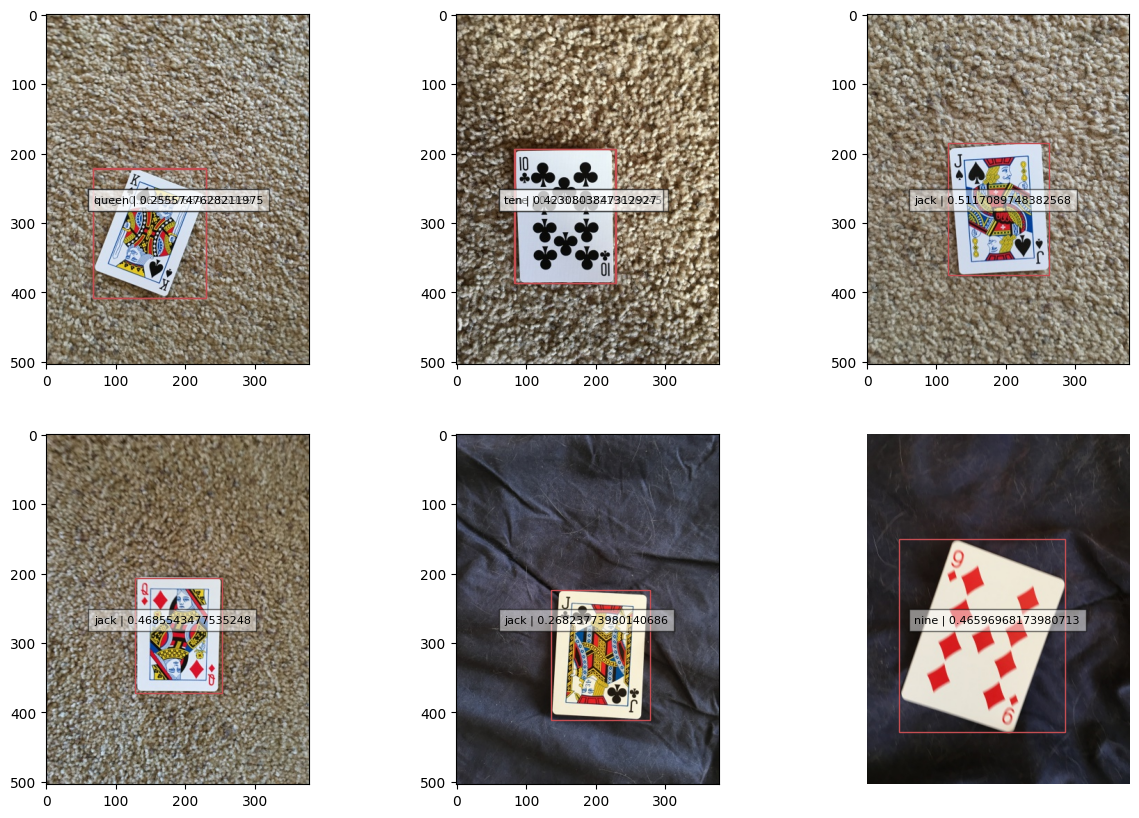

In [ ]:
### YOUR CODE HERE ###
import matplotlib.pyplot as plt
from PIL import Image

test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)
images, targets = batch["image"], batch["target"]
results = yolo.predict("./valid/images/")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, ax in enumerate(axes.flatten()):
    img_path = results[i].path
    img = Image.open(img_path)
    boxes = results[i].boxes

    # Plot the image
    ax.imshow(img)



    # Plot bounding boxes
    for box in boxes:
        xyxy = box.xyxy.cpu().detach().numpy()[0]
        display(xyxy)
        rect = patches.Rectangle(xy = (xyxy[0], xyxy[1]), width = xyxy[2]-xyxy[0], height = xyxy[3]-xyxy[1], linewidth=1, edgecolor="r", facecolor="none")
        ax.add_patch(rect)
        ax.text(xmin, ymin, f"{results[i].names.get(int(box.cls.cpu().detach().numpy()[0]))} | {box.conf.cpu().detach().numpy()[0]}", bbox=dict(facecolor="white", alpha=0.5), fontsize=8)

plt.axis("off")
plt.show()